In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pvlib  # pvlib를 사용하여 일사량 데이터를 처리
from pvlib.location import Location
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

In [2]:
latitude, longitude = 35.0204, 127.3694

In [3]:
location = pvlib.location.Location(latitude, longitude, tz='Asia/Seoul')

# 일일 일사량을 구합니다.
times = pd.date_range(start='2019-09-05', 
                      end = pd.Timestamp('2019-09-05') + pd.Timedelta(days=1) - pd.Timedelta(hours=1), 
                      freq='1H', tz='Asia/Seoul')
solpos = location.get_solarposition(times=times)
dni_extra = pvlib.irradiance.get_extra_radiation(times)
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(location.altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure) 
tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)

# Simplified Solis model을 적용하여 clear sky GHI, DNI, DHI를 얻습니다.
solis_clearsky = pvlib.clearsky.simplified_solis(solpos['apparent_zenith'], am_abs, tl)
cs = location.get_clearsky(times, model='simplified_solis')

# 발전량을 계산합니다.
system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                 module_parameters={'pdc0': 7000, 'gamma_pdc': -0.004}, 
                                 inverter_parameters={'pdc0': 7000},
                                 modules_per_string=1, strings_per_inverter=1,
                                 temperature_model_parameters={'a': -3.56, 'b': -0.075, 'deltaT': 3})
mc = pvlib.modelchain.ModelChain(system, location, spectral_model='no_loss', aoi_model='no_loss')

mc.run_model(solis_clearsky)

mc.results.ac

2019-09-05 00:00:00+09:00       0.000000
2019-09-05 01:00:00+09:00       0.000000
2019-09-05 02:00:00+09:00       0.000000
2019-09-05 03:00:00+09:00       0.000000
2019-09-05 04:00:00+09:00       0.000000
2019-09-05 05:00:00+09:00       0.000000
2019-09-05 06:00:00+09:00       0.000000
2019-09-05 07:00:00+09:00       0.000000
2019-09-05 08:00:00+09:00     301.233472
2019-09-05 09:00:00+09:00     909.326987
2019-09-05 10:00:00+09:00    1371.633764
2019-09-05 11:00:00+09:00    1559.687830
2019-09-05 12:00:00+09:00    1567.712093
2019-09-05 13:00:00+09:00    1568.467436
2019-09-05 14:00:00+09:00    1558.743385
2019-09-05 15:00:00+09:00    1365.071063
2019-09-05 16:00:00+09:00     896.506837
2019-09-05 17:00:00+09:00     288.092655
2019-09-05 18:00:00+09:00       0.000000
2019-09-05 19:00:00+09:00       0.000000
2019-09-05 20:00:00+09:00       0.000000
2019-09-05 21:00:00+09:00       0.000000
2019-09-05 22:00:00+09:00       0.000000
2019-09-05 23:00:00+09:00       0.000000
Freq: H, Name: p

In [4]:
cs['ghi'].sum()

6976.570213159487

In [29]:
def calculate_solar_and_power(lat, lon):
    location = pvlib.location.Location(lat, lon, tz='Asia/Seoul')

    times = pd.date_range(start='2019-09-05', 
                          end=pd.Timestamp('2019-09-05') + pd.Timedelta(days=1) - pd.Timedelta(hours=1), 
                          freq='1H', tz='Asia/Seoul')
    solpos = location.get_solarposition(times=times)
    dni_extra = pvlib.irradiance.get_extra_radiation(times)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(location.altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure) 
    tl = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon)

    solis_clearsky = pvlib.clearsky.simplified_solis(solpos['apparent_zenith'], am_abs, tl)
    
    system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                     module_parameters={'pdc0': 7000, 'gamma_pdc': -0.004}, 
                                     inverter_parameters={'pdc0': 7000},
                                     modules_per_string=1, strings_per_inverter=1,
                                     temperature_model_parameters={'a': -3.56, 'b': -0.075, 'deltaT': 3})
    mc = pvlib.modelchain.ModelChain(system, location, spectral_model='no_loss', aoi_model='no_loss')

    mc.run_model(solis_clearsky)
    ghi_mean = solis_clearsky['ghi'].mean()
    dni_mean = solis_clearsky['dni'].mean()
    dhi_mean = solis_clearsky['dhi'].mean()
    ac_sum = mc.results.ac.sum()

    return ghi_mean, dni_mean, dhi_mean, ac_sum


cities = {
    'Seoul': (37.5665, 126.9780),
    'Busan': (35.1796, 129.0756),
    'Daejeon': (36.3504, 127.3845),
    'Ulsan': (35.5384, 129.3114),
    'Daegu': (35.8714, 128.6014),
    'Gwangju': (35.1595, 126.8526),
    'Gangneung': (37.7519, 128.8761),
    'Gosung' : (38.37698, 128.4689),
    'Cheorwon' : (38.268146, 127.455604),
    'Ganghwa' : (37.784755, 126.274606),
    'Uljin' : (36.888229, 129.412306),
    'Jindo' : (34.486288, 126.257418),
    'Chungju' : (36.987212, 127.921544)    
}

city_data = pd.DataFrame(columns=['GHI', 'DNI', 'DHI', 'AC Power', 'Longitude', 'Latitude'])

for city, (lat, lon) in cities.items():
    ghi, dni, dhi, ac_power = calculate_solar_and_power(lat, lon)
    city_data.loc[city] = [ghi, dni, dhi, ac_power, lon, lat]
        
city_data


,GHI,DNI,DHI,AC Power,Longitude,Latitude
Seoul,208.976705,179.382783,0.426573,11462.958791,126.978000,37.566500
Busan,187.498211,164.581740,0.619366,11322.793255,129.075600,35.179600
Daejeon,206.315414,179.446705,0.534260,11438.988476,127.384500,36.350400
Ulsan,188.359313,164.755830,0.584162,11342.602419,129.311400,35.538400
Daegu,204.942395,178.850468,0.592043,11382.221037,128.601400,35.871400
Gwangju,203.635546,179.391196,0.645330,11403.166887,126.852600,35.159500
Gangneung,192.948582,164.950269,0.391027,11414.186764,128.876100,37.751900
Gosung,194.127775,164.850648,0.342817,11422.652972,128.468900,38.376980
Cheorwon,210.146158,178.777481,0.376807,11437.270727,127.455604,38.268146
Ganghwa,209.714019,179.751398,0.401924,11489.693196,126.274606,37.784755


In [32]:
south_korea_bounds = {
    'lat_min': 33.0,
    'lat_max': 39.0,
    'lon_min': 125.0,
    'lon_max': 131.0
}

In [33]:
m = Basemap(projection='merc', 
            llcrnrlat=33, urcrnrlat=39, 
            llcrnrlon=124, urcrnrlon=132, 
            resolution='i')

In [34]:
grid_x, grid_y = np.mgrid[south_korea_bounds['lon_min']:south_korea_bounds['lon_max']:100j, 
                           south_korea_bounds['lat_min']:south_korea_bounds['lat_max']:100j]

map_x, map_y = m(grid_x, grid_y)

In [70]:
import geopandas as gpd

gdf = gpd.read_file('./ctprvn.shp', encoding='EUC-KR')

In [88]:
map_x

array([[111194.87428468, 111194.87428468, 111194.87428468, ...,
        111194.87428468, 111194.87428468, 111194.87428468],
       [117933.95757466, 117933.95757466, 117933.95757466, ...,
        117933.95757466, 117933.95757466, 117933.95757466],
       [124673.04086464, 124673.04086464, 124673.04086464, ...,
        124673.04086464, 124673.04086464, 124673.04086464],
       ...,
       [764885.95341281, 764885.95341281, 764885.95341281, ...,
        764885.95341281, 764885.95341281, 764885.95341281],
       [771625.03670279, 771625.03670279, 771625.03670279, ...,
        771625.03670279, 771625.03670279, 771625.03670279],
       [778364.11999277, 778364.11999277, 778364.11999277, ...,
        778364.11999277, 778364.11999277, 778364.11999277]])

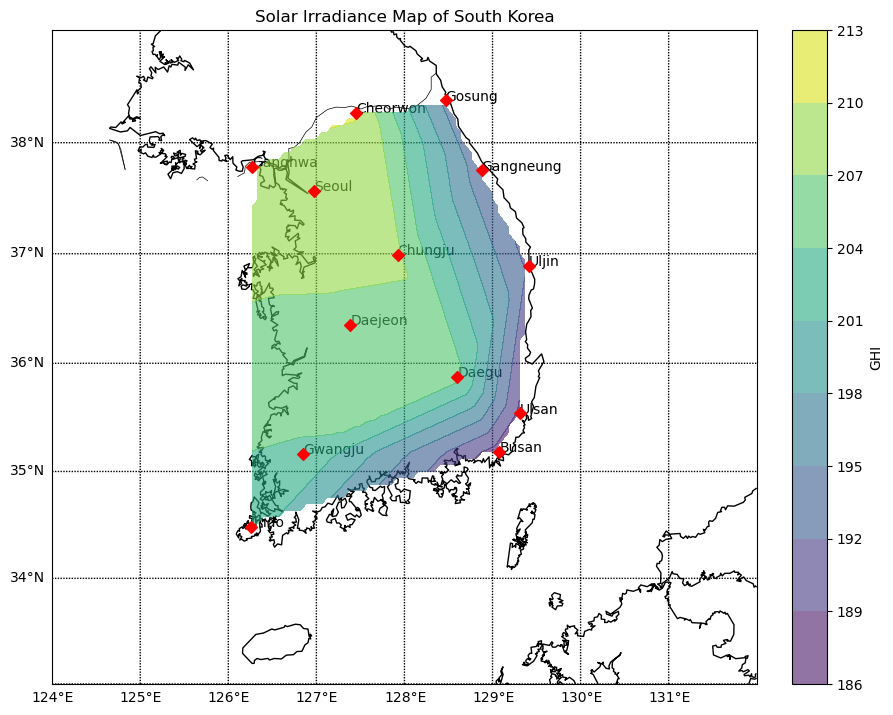

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

m = Basemap(projection='merc', llcrnrlat=33, urcrnrlat=39, llcrnrlon=124, urcrnrlon=132, resolution='i')

m.drawcoastlines()
m.drawcountries()

m.drawparallels(np.arange(33, 39, 1), labels=[1,0,0,0])
m.drawmeridians(np.arange(124, 132, 1), labels=[0,0,0,1])

x, y = m(city_data['Longitude'].tolist(), city_data['Latitude'].tolist())

zi = griddata((x, y), city_data['GHI'].tolist(), (map_x, map_y), method='linear')

cs = m.contourf(map_x, map_y, zi, zorder=6, alpha=0.6, cmap='viridis')

cbar = m.colorbar(cs, location='right', pad="5%")
cbar.set_label('GHI')

m.scatter(x, y, marker='D',color='red', zorder=7)

for label, xpt, ypt in zip(city_data.index, x, y):
    plt.text(xpt, ypt, label)

plt.title('Solar Irradiance Map of South Korea')
plt.show()


In [89]:
gdf

,CTPRVN_CD,CTP_ENG_NM,CTP_KOR_NM,geometry
0,11,Seoul,서울특별시,"POLYGON ((966987.226 1941110.946, 966987.119 1..."
1,26,Busan,부산광역시,"MULTIPOLYGON (((1148194.981 1685460.055, 11481..."
2,27,Daegu,대구광역시,"POLYGON ((1087859.999 1760097.461, 1087859.951..."
3,28,Incheon,인천광역시,"MULTIPOLYGON (((847834.755 1881816.658, 847840..."
4,29,Gwangju,광주광역시,"POLYGON ((932712.687 1696168.692, 932781.680 1..."
5,30,Daejeon,대전광역시,"POLYGON ((990946.725 1832389.260, 991057.692 1..."
6,31,Ulsan,울산광역시,"MULTIPOLYGON (((1167949.952 1710285.043, 11679..."
7,36,Sejong-si,세종특별자치시,"POLYGON ((971235.936 1844386.985, 971234.055 1..."
8,41,Gyeonggi-do,경기도,"MULTIPOLYGON (((931607.470 1894480.382, 931653..."
9,43,Chungcheongbuk-do,충청북도,"POLYGON ((1042689.435 1917662.690, 1042731.339..."
